In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import scipy
import time
import collections
import itertools
import librosa
import pickle
import librosa.display

# Extract Features from Wave Files

In [2]:
#directory to training data and json file
train_dir='/Users/mariechu/Desktop/ML/final/nsynth/nsynth-train/audio/'
#directory to training data and json file
valid_dir='/Users/mariechu/Desktop/ML/final/nsynth/nsynth-valid/audio/'
#directory to training data and json file
test_dir='/Users/mariechu/Desktop/ML/final/nsynth/nsynth-test/audio/'

- Number of Zero Crossings
- max mean mfcc
- centroid mean
- centroid std
- centroid skewness
- max mean contrast
- rolloff mean
- rolloff std
- rolloff skewness
- zero crossing rate mean
- zero crossing rate std
- zero crossing rate skewness

In [3]:
#read the raw json files as given in the training set
df_train_raw = pd.read_json(path_or_buf='/Users/mariechu/Desktop/ML/final/nsynth/nsynth-train/examples.json', orient='index')

In [4]:
#Get a count of instruments in ascending order
n_class_train= df_train_raw['instrument_family'].value_counts(ascending=True)
n_class_train

9      5501
2      8773
10    10208
1     12675
7     13911
8     19474
3     32690
5     34201
6     34477
4     51821
0     65474
Name: instrument_family, dtype: int64

In [5]:
#Sample n files
df_train_sample=df_train_raw.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(5000)) #number of samples
#drop the synth_lead from the training dataset
df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]

In [6]:
df_train_sample.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_110-051-075,266116,16000,51,2,bass,bass_synthetic_110,bass_synthetic_110-051-075,"[distortion, long_release, multiphonic, tempo-...",synthetic,75,0,858,"[0, 0, 1, 0, 1, 1, 0, 0, 0, 1]"
bass_synthetic_126-036-100,239354,16000,36,2,bass,bass_synthetic_126,bass_synthetic_126-036-100,"[distortion, long_release, tempo-synced]",synthetic,100,0,896,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1]"
bass_synthetic_077-046-127,264370,16000,46,2,bass,bass_synthetic_077,bass_synthetic_077-046-127,[fast_decay],synthetic,127,0,692,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
bass_synthetic_062-036-050,195865,16000,36,2,bass,bass_synthetic_062,bass_synthetic_062-036-050,[distortion],synthetic,50,0,611,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_007-081-127,276329,16000,81,2,bass,bass_synthetic_007,bass_synthetic_007-081-127,"[bright, distortion, nonlinear_env]",synthetic,127,0,111,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"


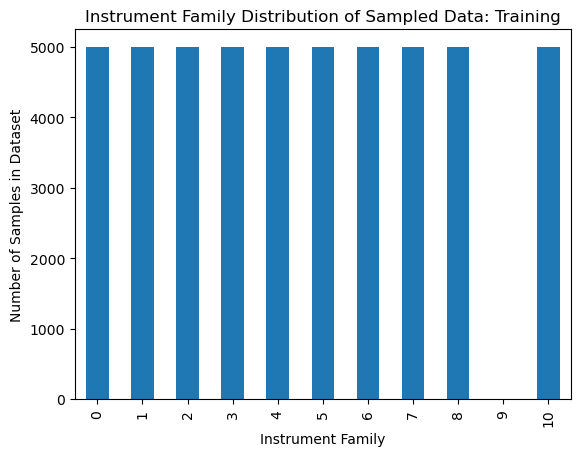

In [7]:
#Display instrument distrution
df_train_sample['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train), 1)).plot(kind = 'bar')
plt.title("Instrument Family Distribution of Sampled Data: Training")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [8]:
#save the train file index as list
filenames_train = df_train_sample.index.tolist()

In [9]:
#save the list to a pickle file
with open('DataWrangling/filenames_train_large.pickle', 'wb') as f:
    pickle.dump(filenames_train, f)

In [10]:
#extract the filenames from the validation dataset
df_valid = pd.read_json(path_or_buf='/Users/mariechu/Desktop/ML/final/nsynth/nsynth-valid/examples.json', orient='index')

# #Sample n files
# df_valid_sample=df_valid_raw.groupby('instrument_family', as_index=False, #group by instrument family
#                                group_keys=False).apply(lambda df: df.sample(100)) #number of samples
# #drop the synth_lead from the validation dataset
# df_valid_sample= df_valid_sample[df_valid_sample['instrument_family']!=9]

#save the validation file index as list
filenames_valid = df_valid.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_valid_large.pickle', 'wb') as f:
    pickle.dump(filenames_valid, f)

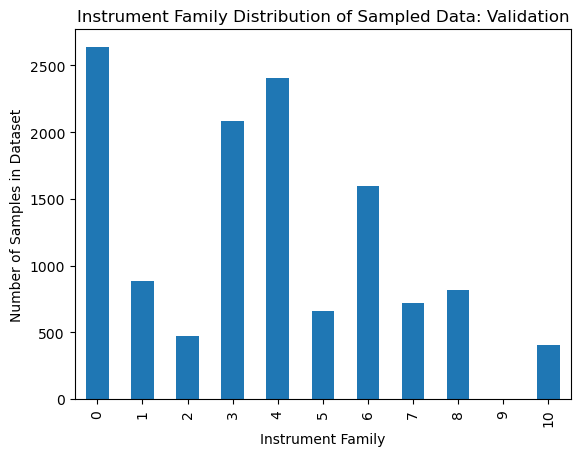

In [11]:
#Display instrument distrution
df_valid['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train), 1)).plot(kind = 'bar')
plt.title("Instrument Family Distribution of Sampled Data: Validation")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [12]:
#extract the filenames from the testing dataset
df_test = pd.read_json(path_or_buf='/Users/mariechu/Desktop/ML/final/nsynth/nsynth-test/examples.json', orient='index')

# #Sample n files
# df_test_sample=df_test_raw.groupby('instrument_family', as_index=False, #group by instrument family
#                                group_keys=False).apply(lambda df: df.sample(100)) #number of samples
# #drop the synth_lead from the testing dataset
# df_test_sample= df_test_sample[df_test_sample['instrument_family']!=9]

#save the test file index as list
filenames_test = df_test.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_test_large.pickle', 'wb') as f:
    pickle.dump(filenames_test, f)

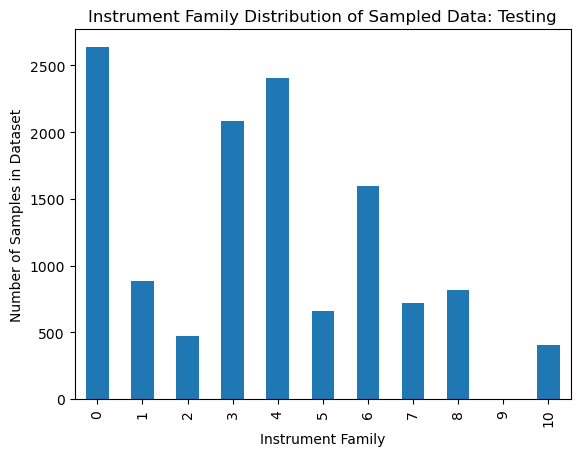

In [13]:
#Display instrument distrution
df_valid['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train), 1)).plot(kind = 'bar')
plt.title("Instrument Family Distribution of Sampled Data: Testing")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [30]:
def feature_extract(file, dataset):
    """
    Define function that takes in a file an returns features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)  
    librosa.display.specshow(librosa.power_to_db(spectrogram,ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig('SpectroImages/'+ dataset + "/" +(file.split("/")[-1].split(".")[0])+'.png')
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    
    #compute chroma energy
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, chroma, contrast]

In [31]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

The function above can take a lot of time for large datasets. It is advisisable to start out on small samples to get an estimate of running time.

## Testing Set

length of test set 1000


/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/

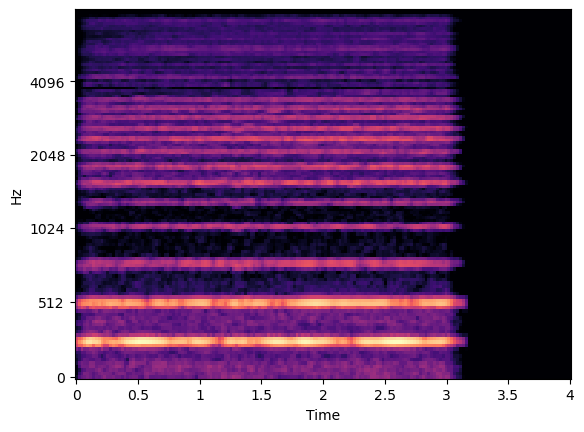

In [34]:
#create dictionary to store all test features
print("length of test set", len(filenames_test))
dict_test = {}
#loop over every file in the list
for file in filenames_test:
    #extract the features
    features = feature_extract(test_dir+ file + '.wav', "test") #specify directory and .wav
    #add dictionary entry
    dict_test[file] = features
    

In [35]:
#convert dict to dataframe
features_test = pd.DataFrame.from_dict(dict_test, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_test.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_electronic_027-049-050,0,"[-520.34467, 36.400047, 28.430422, 25.023615, ...","[0.004846235, 0.10483664, 1.1086023, 2.7106366...","[0.12121492, 0.8226642, 0.08811299, 0.05737854...","[32.05649835683161, 27.949306363385052, 28.392..."
bass_synthetic_033-045-100,1,"[-419.32816, 89.672, 62.640568, 35.73708, 17.7...","[3.1737404, 0.063646264, 0.40452906, 138.14351...","[0.064445995, 0.04328454, 0.038455732, 0.03408...","[28.377300692741496, 26.40948297326512, 31.995..."
bass_synthetic_033-070-100,1,"[-482.88773, 39.416107, 4.5865626, -5.874724, ...","[16.985645, 0.104062475, 0.023573903, 0.008784...","[0.11628871, 0.12491668, 0.09763775, 0.0887368...","[39.76674871177783, 16.822066062802467, 43.212..."
bass_electronic_027-046-100,0,"[-499.99982, 54.164936, 42.82921, 37.18894, 27...","[0.017034588, 0.28810188, 3.4084666, 29.14782,...","[0.050498437, 0.011325962, 0.006643231, 0.0220...","[34.09506502392461, 26.832146082252645, 21.929..."
bass_synthetic_068-032-127,1,"[-546.2686, 58.40211, 47.618397, 42.806427, 34...","[3.3117397, 52.383247, 21.062904, 26.6787, 21....","[0.037829522, 0.02616177, 0.009355875, 0.12255...","[25.243757724106494, 21.320656058276548, 18.24..."


In [36]:
#extract mfccs
mfcc_test = pd.DataFrame(features_test.mfcc.values.tolist(),index=features_test.index)
mfcc_test = mfcc_test.add_prefix('mfcc_')

#extract spectro
spectro_test = pd.DataFrame(features_test.spectro.values.tolist(),index=features_test.index)
spectro_test = spectro_test.add_prefix('spectro_')


#extract chroma
chroma_test = pd.DataFrame(features_test.chroma.values.tolist(),index=features_test.index)
chroma_test = chroma_test.add_prefix('chroma_')


#extract contrast
contrast_test = pd.DataFrame(features_test.contrast.values.tolist(),index=features_test.index)
contrast_test = chroma_test.add_prefix('contrast_')

#drop the old columns
features_test = features_test.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_test=pd.concat([features_test, mfcc_test, spectro_test, chroma_test, contrast_test],
                           axis=1, join='inner')
df_features_test.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_electronic_027-049-050,0,-520.344666,36.400047,28.430422,25.023615,18.087437,10.788898,4.570021,-2.027889,-6.416580,...,0.088113,0.057379,0.051059,0.047662,0.055104,0.068820,0.099955,0.114785,0.089922,0.105773
bass_synthetic_033-045-100,1,-419.328156,89.671997,62.640568,35.737080,17.742739,7.531154,1.173620,-2.856841,-4.548405,...,0.038456,0.034080,0.346660,0.042374,0.017896,0.040461,0.300225,0.757362,0.145503,0.054674
bass_synthetic_033-070-100,1,-482.887726,39.416107,4.586563,-5.874724,-3.119999,-5.453631,-8.653055,-7.475647,-7.137695,...,0.097638,0.088737,0.069463,0.046776,0.045119,0.039376,0.054012,0.015925,0.778826,0.242188
bass_electronic_027-046-100,0,-499.999817,54.164936,42.829208,37.188938,27.455603,19.024326,11.890820,4.562567,-1.346954,...,0.006643,0.022051,0.033160,0.132244,0.054438,0.091827,0.100805,0.193402,0.848749,0.082599
bass_synthetic_068-032-127,1,-546.268616,58.402111,47.618397,42.806427,34.833782,29.456072,23.442659,20.130299,16.629026,...,0.009356,0.122558,0.005306,0.006644,0.039938,0.169573,0.825710,0.191867,0.051979,0.000000


In [37]:
targets_test = []
for name in df_features_test.index.tolist():
    targets_test.append(instrument_code(name))

df_features_test['targets'] = targets_test

In [38]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_new_test.pickle', 'wb') as f:
    pickle.dump(df_features_test, f)

In [39]:
df_features_test.shape

(1000, 167)

## Traning Set

In [ ]:
start_train = time.time()
print("length of train set", len(filenames_train))
#create dictionary to store all test features
dict_train = {}
#loop over every file in the list
for file in filenames_train:
    #extract the features
    features = feature_extract(train_dir+ file + '.wav', 'train') #specify directory and .wav
    #add dictionary entry
    dict_train[file] = features

end_train=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_train), end_train - start_train))

length of train set 10000


/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/

/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/music/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)
/Users/mariechu/opt/anaconda3/envs/

In [ ]:
#convert dict to dataframe
features_train = pd.DataFrame.from_dict(dict_train, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_train.head()

In [ ]:
#extract mfccs
mfcc_train = pd.DataFrame(features_train.mfcc.values.tolist(),
                          index=features_train.index)
mfcc_train = mfcc_train.add_prefix('mfcc_')

#extract spectro
spectro_train = pd.DataFrame(features_train.spectro.values.tolist(),
                             index=features_train.index)
spectro_train = spectro_train.add_prefix('spectro_')


#extract chroma
chroma_train = pd.DataFrame(features_train.chroma.values.tolist(),
                            index=features_train.index)
chroma_train = chroma_train.add_prefix('chroma_')


#extract contrast
contrast_train = pd.DataFrame(features_train.contrast.values.tolist(),
                              index=features_train.index)
contrast_train = chroma_train.add_prefix('contrast_')

#drop the old columns
features_train = features_train.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_train=pd.concat([features_train, mfcc_train, spectro_train, chroma_train, contrast_train],
                           axis=1, join='inner')
df_features_train.head()

In [ ]:
targets_train = []
for name in df_features_train.index.tolist():
    targets_train.append(instrument_code(name))


In [ ]:
df_features_train['targets'] = targets_train

In [ ]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_new_train.pickle', 'wb') as f:
    pickle.dump(df_features_train, f)

In [ ]:
df_features_train.shape

## Validation Set

In [ ]:
start_valid = time.time()

print("length of valid set", len(filenames_valid))
#create dictionary to store all test features
dict_valid = {}
#loop over every file in the list
for file in filenames_valid:
    #extract the features
    features = feature_extract(valid_dir+ file + '.wav', valid) #specify directory and .wav
    #add dictionary entry
    dict_valid[file] = features

end_valid=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_valid), end_valid - start_valid))

In [ ]:
#convert dict to dataframe
features_valid = pd.DataFrame.from_dict(dict_valid, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_valid.head()

In [ ]:
#extract mfccs
mfcc_valid = pd.DataFrame(features_valid.mfcc.values.tolist(),
                          index=features_valid.index)
mfcc_valid = mfcc_valid.add_prefix('mfcc_')

#extract spectro
spectro_valid = pd.DataFrame(features_valid.spectro.values.tolist(),
                             index=features_valid.index)
spectro_valid = spectro_valid.add_prefix('spectro_')


#extract chroma
chroma_valid = pd.DataFrame(features_valid.chroma.values.tolist(),
                            index=features_valid.index)
chroma_valid = chroma_valid.add_prefix('chroma_')


#extract contrast
contrast_valid = pd.DataFrame(features_valid.contrast.values.tolist(),
                              index=features_valid.index)
contrast_valid = chroma_valid.add_prefix('contrast_')

#drop the old columns
features_valid = features_valid.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_valid=pd.concat([features_valid, mfcc_valid, spectro_valid, chroma_valid, contrast_valid],
                           axis=1, join='inner')
df_features_valid.head()

In [ ]:
targets_valid = []
for name in df_features_valid.index.tolist():
    targets_valid.append(instrument_code(name))

df_features_valid['targets'] = targets_valid

In [ ]:
df_features_valid.shape

In [ ]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_valid_new.pickle', 'wb') as f:
    pickle.dump(df_features_valid, f)

# Get Mel Spectogram images

In [51]:
start_train = time.time()

with open("DataWrangling/df_features_test.pickle", 'rb') as f:
    df_test = pickle.load(f)
print(df_test.shape)

#create dictionary to store all test features
dict_train = {}
#loop over every file in the list
spec = df_test.to_numpy()[:, 14:142]
print("shape", spec.shape)
for (i,file) in enumerate(filenames_test):
#     #extract the features
#     features = feature_extract(train_dir+ file + '.wav') #specify directory and .wav
#     #add dictionary entry
#     dict_train[file] = features
    print(test_dir + file + '.wav')
    plt.figure(figsize=(10,4))
    S = spec[i]
#     S = df_test.loc[i, 14:141].values.flatten().tolist()
#     values[14:141].flatten().tolist()
    print("length", S.shape)
    print(df_test.keys()[14])
    print(df_test.keys()[141])
    librosa.display.specshow(librosa.power_to_db(S,ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title("Mel spectrogram for " + instrument)
    plt.savefig('SpectroImages/'+str(file)+'.png')
    
    break

end_train=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_train), end_train - start_train))

(4096, 167)
shape (4096, 128)
/Users/mariechu/Desktop/ML/final/nsynth/nsynth-test/audio/bass_synthetic_068-049-025.wav
length (128,)
spectro_0
spectro_127


IndexError: tuple index out of range

<Figure size 1000x400 with 0 Axes>

# Clean JSON Files

In [39]:
#extract qualities
train_qual = pd.DataFrame(df_train_sample.qualities.values.tolist(), index= df_train_sample.index)


#concatenate
json_train=pd.concat([df_train_sample, train_qual],
                           axis=1, join='inner')

json_train= json_train.drop(labels=['qualities'], axis=1)
json_train.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,...,0,1,2,3,4,5,6,7,8,9
bass_electronic_016-038-100,268409,16000,38,1,bass,bass_electronic_016,bass_electronic_016-038-100,[distortion],electronic,100,...,0,0,1,0,0,0,0,0,0,0
bass_synthetic_007-027-075,206320,16000,27,2,bass,bass_synthetic_007,bass_synthetic_007-027-075,"[distortion, nonlinear_env]",synthetic,75,...,0,0,1,0,0,0,1,0,0,0
bass_synthetic_006-021-050,267472,16000,21,2,bass,bass_synthetic_006,bass_synthetic_006-021-050,"[bright, distortion, multiphonic]",synthetic,50,...,1,0,1,0,0,1,0,0,0,0
bass_synthetic_091-062-127,285884,16000,62,2,bass,bass_synthetic_091,bass_synthetic_091-062-127,"[bright, distortion]",synthetic,127,...,1,0,1,0,0,0,0,0,0,0
bass_synthetic_040-094-100,217133,16000,94,2,bass,bass_synthetic_040,bass_synthetic_040-094-100,"[bright, distortion, fast_decay, multiphonic]",synthetic,100,...,1,0,1,1,0,1,0,0,0,0


In [40]:
#save the dataframe to a pickle file
with open('DataWrangling/json_train.pickle', 'wb') as f:
    pickle.dump(json_train, f)

In [41]:
#extract qualities
test_qual = pd.DataFrame(df_test.qualities.values.tolist(), index= df_test.index)


#concatenate
json_test=pd.concat([df_test, test_qual],
                           axis=1, join='inner')

json_test= json_test.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_test.pickle', 'wb') as f:
    pickle.dump(json_test, f)

In [42]:
#extract qualities
valid_qual = pd.DataFrame(df_valid.qualities.values.tolist(), index= df_valid.index)


#concatenate
json_valid=pd.concat([df_valid, valid_qual],
                           axis=1, join='inner')

json_valid= json_valid.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_valid.pickle', 'wb') as f:
    pickle.dump(json_valid, f)